#### **Welcome to Assignment 6 - Question 2, on Deep Learning for Computer Vision.**
In this assignment you will get a chance to implement Projected Gradient Descent and Rotation based Self Supervised Learning Technique .

#### **Instructions**
1. Use Python 3.x to run this notebook
3. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.Necessary comments are provided within the lines to help you in the implementation, you sould not change anything else code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
4. Read documentation of each function carefully.
5. All the Best!
6. Total Marks: 11

### Question 1 : Implement Projected Gradient Descent

Given a sample test image and a pretrained model, generate a corresponding adversarial image using Projected gradient Descent(PGD). The following attack configuration MUST be follwed in order to generate the adversarial image: step size = 2/255, epsilon = 0.3 and number_of_steps = 40. 
 

In [ ]:
# 4-Mark

--2021-04-26 10:56:51--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-26 10:56:52--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.4’

MNIST.tar.gz.4          [            <=>     ]  33.20M  6.38MB/s    in 5.5s    

2021-04-26 10:56:58 (6.09 MB/s) - ‘MNIST.tar.gz.4’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

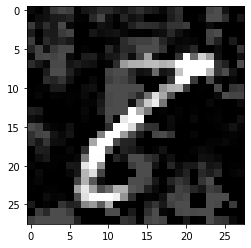

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Set for testing purposes, please do not change!
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


epsilons = 0.3
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        #return F.log_softmax(x, dim=1)

# The following block is to mitigate the temporary issue within PyTorch about downloading MNIST. Don't change!
new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
datasets.MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in datasets.MNIST.resources
]
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

## Implement Projected Gradient Descent algorithm

### YOUR CODE STARTS HERE
def PGD_attack(data, target, model):
    step_size = 2/255
    epsilon = 0.3
    number_of_steps = 40

    data = data.detach()
    target = target.detach()
    loss = nn.CrossEntropyLoss()
    adv_data = data.detach()

    for i in range(number_of_steps):
        adv_data.requires_grad = True
        outputs = model(adv_data)
        cost = -1*loss(outputs, target)

        grad = torch.autograd.grad(cost, adv_data)[0]

        adv_data = adv_data.detach() - step_size*grad.sign()
        pertub = torch.clamp(adv_data - data, -epsilon, epsilon)
        adv_data = torch.clamp(data + pertub, 0, 1).detach()

    return adv_data

### YOUR CODE ENDS HERE

def test( model, device, data, target, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    ### generate the perturbed image using PGD    
    perturbed_data = PGD_attack(data, target, model)
        
    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    if final_pred.item() == target.item():
        correct += 1
    else:
        pass
    # Return the accuracy and an adversarial example
    return final_pred, perturbed_data

for data,target, in test_loader:
    data = data[0:1,:,:,:]
    target = target[0:1]
    break


pred_adv, adv_ex = test(model, device, data,target, epsilons)
print ("Predicted class for perturbed image: ",pred_adv)


### YOUR CODE STARTS HERE


#Compute the mean pixel value of the adversarial image and print the value
print(torch.mean(adv_ex))

#Visualize the adversarial image, show the image
plt.imshow(adv_ex.reshape(28,28).cpu().data.numpy(), cmap="gray")


### YOUR CODE ENDS HERE

### Question 1 (1 mark): Find out the predicted class when the adversarial image generated in the previous step is fed to the pretrained model ? 

We get predicted class as tensor([[8]]) as given above. So the predicted class is 8.

### Question 2 (1 mark): Visualize The adversarial image generated  using the exactly same setup as in previous question and find out the mean pixel intensity of that adversarial image?

Mean pixel intensity:  0.15995147824287415
Generated adversial image: 


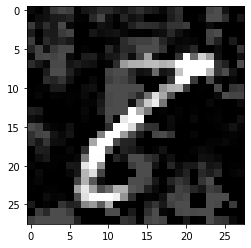

In [ ]:
print("Mean pixel intensity: ",torch.mean(adv_ex).item())

print("Generated adversial image: ")
plt.imshow(adv_ex.reshape(28,28).cpu().data.numpy(), cmap="gray")


### Question:3 Rotation Based Self Supervision Task


Please consider the modified LeNet model with below model definition:

Shared layers (1 to 4)


1.   Conv layer with 10 output channels and filter size 5
2.   Conv layer with 20 output channels and filter size 5
3.   Dropout layer
4.   Fully connected layer with output size 50
5.   Branch out 2 heads i.e. main classification and rotation  classification heads.

  *   Takes input from step 4 and outputs 10 dimensions(main class labels) through a fully connected layer
  *   Takes input from step 4 and outputs 4 dimensions(rotation class labels) through a fully connected layer

 

This model is basically a Y-shaped model where the trail is shared layers and 2 heads are for main classification and rotation classification. 
A model with above definition is trained for 20 epochs and the resulting trained model is shared with you. 
Some steps in the forward function are kept blank for you to fill up. You have to load the model and properly, write those steps in the forward function to be able to run the model. Please note that without these steps properly written, you won't be able to run the model. Once you do this, please answer the below question.



In [ ]:
# 4-Mark

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-26 15:24:48--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-26 15:24:48--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  10.4MB/s    in 3.2s    

2021-04-26 15:24:52 (10.4 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
# -*- coding: utf-8 -*-

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
# import matplotlib.pyplot as plt
import torch.utils.data
import numpy as np


import torchvision
import torchvision.transforms as transforms
torch.manual_seed(1)

# Assumes that tensor is (nchannels, height, width)
def tensor_rot_90(x):
    return x.flip(2).transpose(1, 2)

def tensor_rot_180(x):
    return x.flip(2).flip(1)

def tensor_rot_270(x):
    return x.transpose(1, 2).flip(2)

def rotate_batch_with_labels(batch, labels):
    images = []
    for img, label in zip(batch, labels):
        if label == 1:
            img = tensor_rot_90(img)
        elif label == 2:
            img = tensor_rot_180(img)
        elif label == 3:
            img = tensor_rot_270(img)
        images.append(img.unsqueeze(0))
    return torch.cat(images)

def rotate_batch(batch, label):
    if label == 'rand':
        labels = torch.randint(4, (len(batch),), dtype=torch.long)
    elif label == 'expand':
        labels = torch.cat([torch.zeros(len(batch), dtype=torch.long),
                    torch.zeros(len(batch), dtype=torch.long) + 1,
                    torch.zeros(len(batch), dtype=torch.long) + 2,
                    torch.zeros(len(batch), dtype=torch.long) + 3])
        batch = batch.repeat((4,1,1,1))
    else:
        assert isinstance(label, int)
        labels = torch.zeros((len(batch),), dtype=torch.long) + label
    return rotate_batch_with_labels(batch, labels), labels

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc2_ssl = nn.Linear(50, 4)

    ### network architecture for classification head: 
    ### conv1 -> maxpool2D-> Relu->conv2->conv2_drop->maxpool2D->Relu->Reshape->fc1->Relu->dropout->fc2,fc2_ssl
    def forward(self, x):
        ### YOUR CODE STARTS HERE
        out = F.relu(F.max_pool2d(self.conv1(x), 2))
        out = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(out)), 2))
        out = out.view(-1, 320)
        out = F.dropout(F.relu(self.fc1(out)))
        x1 = self.fc2(out)
        x2 = self.fc2_ssl(out)

        return x1,x2

        ### YOUR CODE ENDS HERE

# MNIST Test dataset and dataloader declaration
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

# the datasets
trainset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='.', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Initialize the network
net = Net().to(device)

parameters = list(net.parameters())
optimizer = optim.SGD(parameters, lr=0.1, momentum=0.9, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss().to(device)
print('Running...')

def train(epoch):
    net.train()    
    
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)        
        labels_full = labels.repeat(4)            
        
        ## Self supervised head
        inputs_ssh, labels_ssh = rotate_batch(inputs, "expand")
        inputs_ssh, labels_ssh = inputs_ssh.to(device), labels_ssh.to(device)
        # outputs_clh , outputs_ssh denotes classification head output and self supervision head output respectively 
        outputs_clh, outputs_ssh = net(inputs_ssh) 
        loss = criterion(outputs_clh, labels_full)
        loss_ssh = criterion(outputs_ssh, labels_ssh)
        loss += loss_ssh

        loss.backward()
        optimizer.step()

    print(('Epoch %d: %f' %(epoch,loss.item())))
    torch.save(net, "ssl_mnist.pt")


## Funtion to compute test accuracy using model already trained with additional self-supervised head..
def test():
    main_correct = 0
    class_correct = 0

    ### YOUR CODE STARTS HERE
    model = torch.load("./ssl_mnist.pt", map_location='cpu')
    model.to(device)
    model.eval()
    # net.load_state_dict(torch.load("./ssl_mnist.pt", map_location='cpu'))
    # net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)        
            labels_full = labels.repeat(4)            
            
            ## Self supervised head
            inputs_ssh, labels_ssh = rotate_batch(inputs, "expand")
            inputs_ssh, labels_ssh = inputs_ssh.to(device), labels_ssh.to(device)
            # outputs_clh , outputs_ssh denotes classification head output and self supervision head output respectively 
            main_labels, class_labels = net(inputs_ssh) 
            # print(main_labels.shape)
            # print(labels_full.shape)
            
            _, main_pred_labels = torch.max(main_labels,dim=1)
            main_correct += (main_pred_labels == labels_full).sum()
            
            _, class_pred_labels = torch.max(class_labels, dim=1)
            class_correct += (class_pred_labels == labels_ssh).sum()
    
    return main_correct, class_correct, len(testloader.dataset)
        
    ### YOUR CODE ENDS HERE

### Training Loop
# for epoch in range(0, 20):
#     train(epoch)

# train(1)
main_correct, class_correct, num_samples = test()

print("Classification head accuracy: ", (100. * main_correct / num_samples).item())
print("Self supervision accuracy: ", (100. * class_correct / num_samples).item())

CUDA Available:  False
Running...


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:623: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u

Classification head accuracy:  43.97999954223633
Self supervision accuracy:  97.12000274658203


### 1-Mark
### What is the model test accuracy on MNIST test dataset

In [ ]:
print("Classification head accuracy: ", (100. * main_correct / num_samples).item())
print("Self supervision accuracy: ", (100. * class_correct / num_samples).item())

Classification head accuracy:  43.97999954223633
Self supervision accuracy:  97.12000274658203
